<a href="https://colab.research.google.com/github/data602sps/assignments/blob/master/08_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project Part 2 - Kaggle Competition Model
## Donny Lofland DATA605 5/17/2020

### Kaggle Ames, Iowa Housing Dataset

In 2011, Dean De Cook (Truman State University) published this famous dataset in the *Journal of Statistics Education*.  This dataset was published as a suggested alternative to the other common toy dataset, Boston Housing Prices.  This dataset contains a richer set of features (80) and is intended as an example dataset for undergraduate and graduate projects.  The abstract provided by De Cook,

> "This paper presents a data set describing the sale of individual residential property in Ames, Iowa
from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory
variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home
values. I will discuss my previous use of the Boston Housing Data Set and I will suggest
methods for incorporating this new data set as a final project in an undergraduate regression
course."

This dataset tracks residential property sales in Ames, Iowa, and provides the sale price along with a rich set of features describing each property.

Kaggle.com, an online platform for Data Science competitions created an ongoing project to allow students to explore this dataset with the goal to build models that predict housing prices based on provided features.  Kaggle.com has a rolling competition that lets participants submit models that are applied against a holdout dataset and participants are ranked on a leaderboard based on how well they performed.  This dataset provides a rich set of features that can be used for any number of modeling approaches including but not limited to linear regression, multiple regression, decision trees, and neural networks.  While the Kaggle goal is to predict housing prices, this dataset is rich enough that one could also test out different classification techniques to segment properties and explore relationships.  For my project, I will restrict my focus to simple multiple regression (per our Project Instructions). 

### Data Resources & References

* Kaggle.com, "House Prices: Advanced Regression Techniques,"  https://www.kaggle.com/c/house-prices-advanced-regression-techniques
* De Cook, D. (2011). "Ames, Iowa: Alternative to the Boston Housing Data as an
End of Semester Regression Project," *Journal of Statistics Education* , Volume 19, Number 3(2011) http://www.amstat.org/publications/jse/v19n3/decock.pdf
* Harrison, D. and Rubinfeld, D. L. (1978). “Hedonic Housing Prices and the Demand for Clean Air,” *Journal of Environmental Economics and Management*, 5, 81-102.
* "Boston Housing Dataset,' http://lib.stat.cmu.edu/datasets/boston


In [1]:
%matplotlib inline

# Import Python libraries
import sys
import os
import math
import boto3
import time
import datetime
import pandas as pd
import numpy as np

# Modeling libraries and methods
import statsmodels.api as sm 
from scipy import stats
from scipy.stats import zscore
import pylab as py
import statsmodels.formula.api as smf
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split


# Import model and estimator packages
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

# ----- Visualization Libraries -----
import matplotlib.pyplot as plt
import seaborn as sns; 
sns.set(style="ticks", color_codes=True)

# ----- DataBase Connector -----

# Note: The DB credentials are stored in a file outside of the project.  When imported,
# env variables are setup including os.env['DB_USER'], 'DB_PASS', etc.  This prevents
# accidentally leaking credentials when sharing the project and/or reports.
sys.path.append('/Users/dlofland/temp/')
from db_credentials import *

# Allow Jupyter and Pandas to Display all columns and row
pd.option_context('display.max_rows', None, 'display.max_columns', None)

______________
# Data Exploration  (EDA)
Import your dataset into your **python** environment and explore your data.  You should include any summary statistics, means, medians, quartiles, or any other relevant information about the dataset.

### Load training dataset

In [2]:
# Read training dataset and setup DataFrame for exploration and modeling
ames_df = pd.read_csv('./datasets/train.csv')
ames_df.set_index('Id', inplace=True)
ames_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Verify Column DataTypes (fix if necessary)

In [3]:
print(ames_df.dtypes.to_string())

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object


In [4]:
# Verify the Columns that loaded - review this against the data_dictionary.txt
print(ames_df.columns)

# Quick View on means, standard deviations and IQR
ames_df.describe()

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Summary Statistics

Please see the full Data Descriptions at https://./datasets/data_descriptions.txt

**Note: the data_diction.txt file has an error - Bedroom is actually BedroomAbvGr**

* **Continuous Features:** LotFrontage, **LotArea**, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, **2ndFlrSF**, LowQualFinSF, **GrLivArea**, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, **PoolArea**, **MiscVal**
* **Discrete Features:** BsmtFullBath, BsmtHalfBath, **FullBath**, **HalfBath**, **Bedroom**, Kitchen, TotRmsAbvGrd, Fireplaces, **GarageCars**
* **Nominal Categorical Features:** MSSubClass, MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, **Neighborhood**, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, **Exterior1st**, Exterior2nd, MasVnrType, Foundation, Heating, **CentralAir**, Electrical, GarageType, MiscFeature, **SaleType**, **SaleCondition**
* **Ordinal Categorial Features:** OverallQual, **OverallCond**, **YearBuilt**, YearRemodAdd, **ExterQual**, ExterCond, **BsmtQual**, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, **HeatingQC**, KitchenQual, **Functional**, FireplaceQu, GarageYrBlt, GarageFinish, GarageQual, GarageCond, **PavedDrive**, PoolQC, Fence, **MoSold**, **YrSold** 

* **Target Variable:** **SalePrice**

### Initial *Feature Plan* based on Data Descriptions:

I've identified a subset of features that I suspect have a greater contribution to the **SalePrice**, based on personal history purchasing houses.  While every feature might offer some degree of resolution on **SalePrice**, including too many features will create a more complex model and provide less explanatory insights.  For each feature below, I'll check for correlations with **SalePrice**.  Once we identify those variables that provide some explanatory value, we will then check for autocorrelations between them to see if any should be dropped out.  Ideally, I'll reduce this list to a handful of features to include in the final model.

_Continuous Features_

* **LotArea:** Larger lots may be reflected in the price.  Note, this feature might correlate with **Neighborhood**.
* **TotalBsmtSF, GrLivArea:** Transform and combine both into **TotalSF** 
* **MiscVal:** Check if this correlated with final **SalePrice** - if so, then include it.  
* **PoolArea:** Transform this to a boolean, **Pool** - *1* (there is there a pool) or *0* (no pool).

_Nominal Categorical_

* **Neighborhood:** The neighborhood very likely influences price.
* **Exterior1st:** Transform into **ExtMasonry** (Combine all Brick/Stone/Stucco into *1*, and all others into *0*)
* **BsmtCond:** Transform into a boolean, **Basement**, *1* (yes) or *0* (no).
* **CentralAir:** Transform to a boolen, **HasAC**, *1* (yes) or *0* (no).
* **Functional:** Transform to a boolean, **Typical**, *1* ("Typical") or *0* ("Non-typical").  
* **PavedDrive:** Tranform to boolean, **Driveway** - is it *1* (fully paved) or *0* (not fully paved).
* **SaleCondition:** Bucket into *1* ("normal") or *0* (all "non-normal").  The "non-normal" sales are likely edge cases and may introduce increased variability.
* **MoSold:** There may be seasonal effects on prices based on month sold (e.g. high demand months versus non-demand months).

_Ordinal Categorial_

* **OverallCond:** House condition probably impacts price.
* **MoSold, YrSold:** Transform into a single date object **DateSold**. 

_Discrete Numerical_

* **YearBuilt:** 
* **FullBath, HalfBath:** Transform and combine into a single value **Baths**
* **BedroomAbvGr:** Number of bedrooms is often important to buyers.
* **GarageCars:** Number of cars garage hold is often an important feature for buyers.

### General Thoughts:

* Houses are in competition with each other when placed on the market, so each record is not necessarily independent.  There are certainly some dependencies between houses sold during the same month.
* Initial prices are often influenced by recently sold houses, so there is likely a lagged effect on price based on recent sales.
* There are probably features to a home that are not captured in the basic dataset that have profound impacts on sale price.
* I would have liked to have seen **TimeOnMarket**, **TimeToSale** or **InitialSalePrice** vs **FinalSalePrice** to better understand house sellability.  If I were conducting a more rigorous analysis, I would probably look at those years to see if I could find any other datasets to understand the market in Ames.
* The Housing Bubble occurred during the early 2000's and the Housing Crash started ~2009, both of which overlap the dataset.  As such, any model while it may predict homes during this time frame may be skewed and certainly may not hold up outside of the data window.



#### Check for Nulls

In [5]:
# Find columns with Nulls - see if we care about any of them for this analysis
cols = [c[0] for c in ames_df.isnull().sum().iteritems() if c[1] > 0]
print('Columns with Nulls: ', cols, "\n")


Columns with Nulls:  ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'] 



The Nulls are present with Nominal Feature (as expected from data_dictionary.txt) and are used to indicate the property didn't have that feature.  For this analysis, the only one I miught care about is **BsmtCond**.

#### Print values and counts for a few features we might care about

I am possibly interested in several Nominal (categorical) features.  Let's check which values are present and the counts.

In [6]:
print('BsmtCond unique values: ', ames_df['BsmtCond'].unique(), "\n")
print(ames_df.groupby('BsmtCond')['BsmtCond'].count(), "\n")

print('Exterior1st unique values: ', ames_df['Exterior1st'].unique(), "\n")
print(ames_df.groupby('Exterior1st')['Exterior1st'].count(), "\n")

print('Functional unique values: ', ames_df['Functional'].unique(), "\n")
print(ames_df.groupby('Functional')['Functional'].count(), "\n")

print('PavedDrive unique values: ', ames_df['PavedDrive'].unique(), "\n")
print(ames_df.groupby('PavedDrive')['PavedDrive'].count(), "\n")

print('SaleCondition unique values: ', ames_df['SaleCondition'].unique(), "\n")
print(ames_df.groupby('SaleCondition')['SaleCondition'].count(), "\n")


BsmtCond unique values:  ['TA' 'Gd' nan 'Fa' 'Po'] 

BsmtCond
Fa      45
Gd      65
Po       2
TA    1311
Name: BsmtCond, dtype: int64 

Exterior1st unique values:  ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock'] 

Exterior1st
AsbShng     20
AsphShn      1
BrkComm      2
BrkFace     50
CBlock       1
CemntBd     61
HdBoard    222
ImStucc      1
MetalSd    220
Plywood    108
Stone        2
Stucco      25
VinylSd    515
Wd Sdng    206
WdShing     26
Name: Exterior1st, dtype: int64 

Functional unique values:  ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev'] 

Functional
Maj1      14
Maj2       5
Min1      31
Min2      34
Mod       15
Sev        1
Typ     1360
Name: Functional, dtype: int64 

PavedDrive unique values:  ['Y' 'N' 'P'] 

PavedDrive
N      90
P      30
Y    1340
Name: PavedDrive, dtype: int64 

SaleCondition unique values:  ['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Fam

* **Basements:** Apparently basements are very common in Ames.  Since most homes have a basement and most are Fair or better.  I'll probably not include this feature in the analysis.
* **Exterior:** The main exterior types are wood, metal, vinyl and to a less extent masonry.  I'll need to see if any of these have strong correlations with the price.
* **Functional:** Less than 10% of properties are Non-typical - I'll probably bucket all those into a single group and check it's spread.  If there is a clear pattern with Price, maybe it's valuable to include.
* **SaleCondition:** The dataset author recommends only including "Normal" sales as the other types are edge cases and more difficult to account for.


## Quick Visualizations to undersand Raw Features

#### Explore Numeric Features

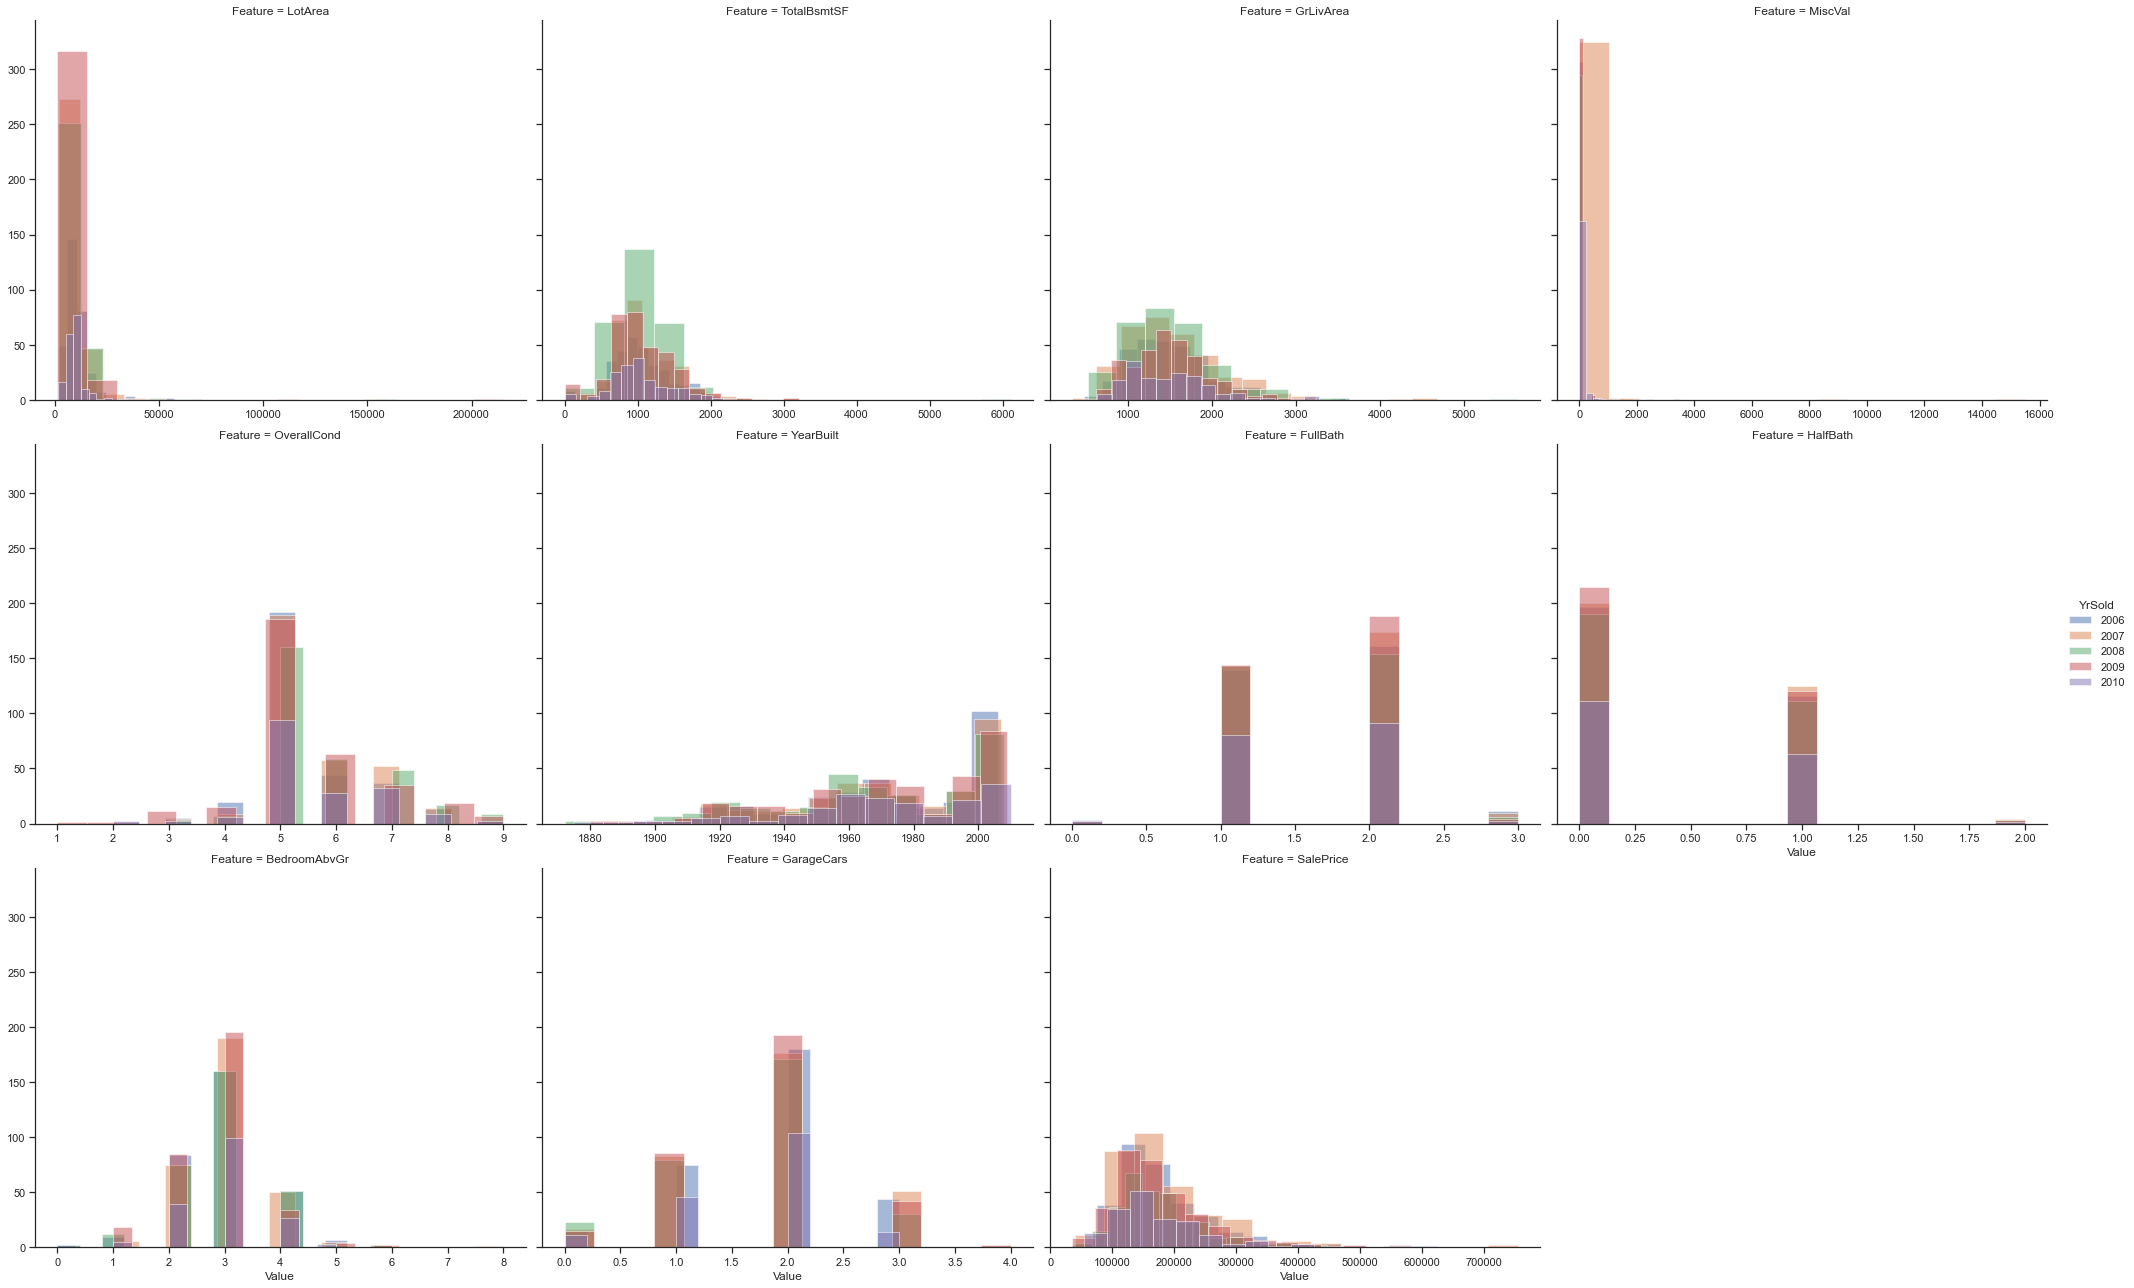

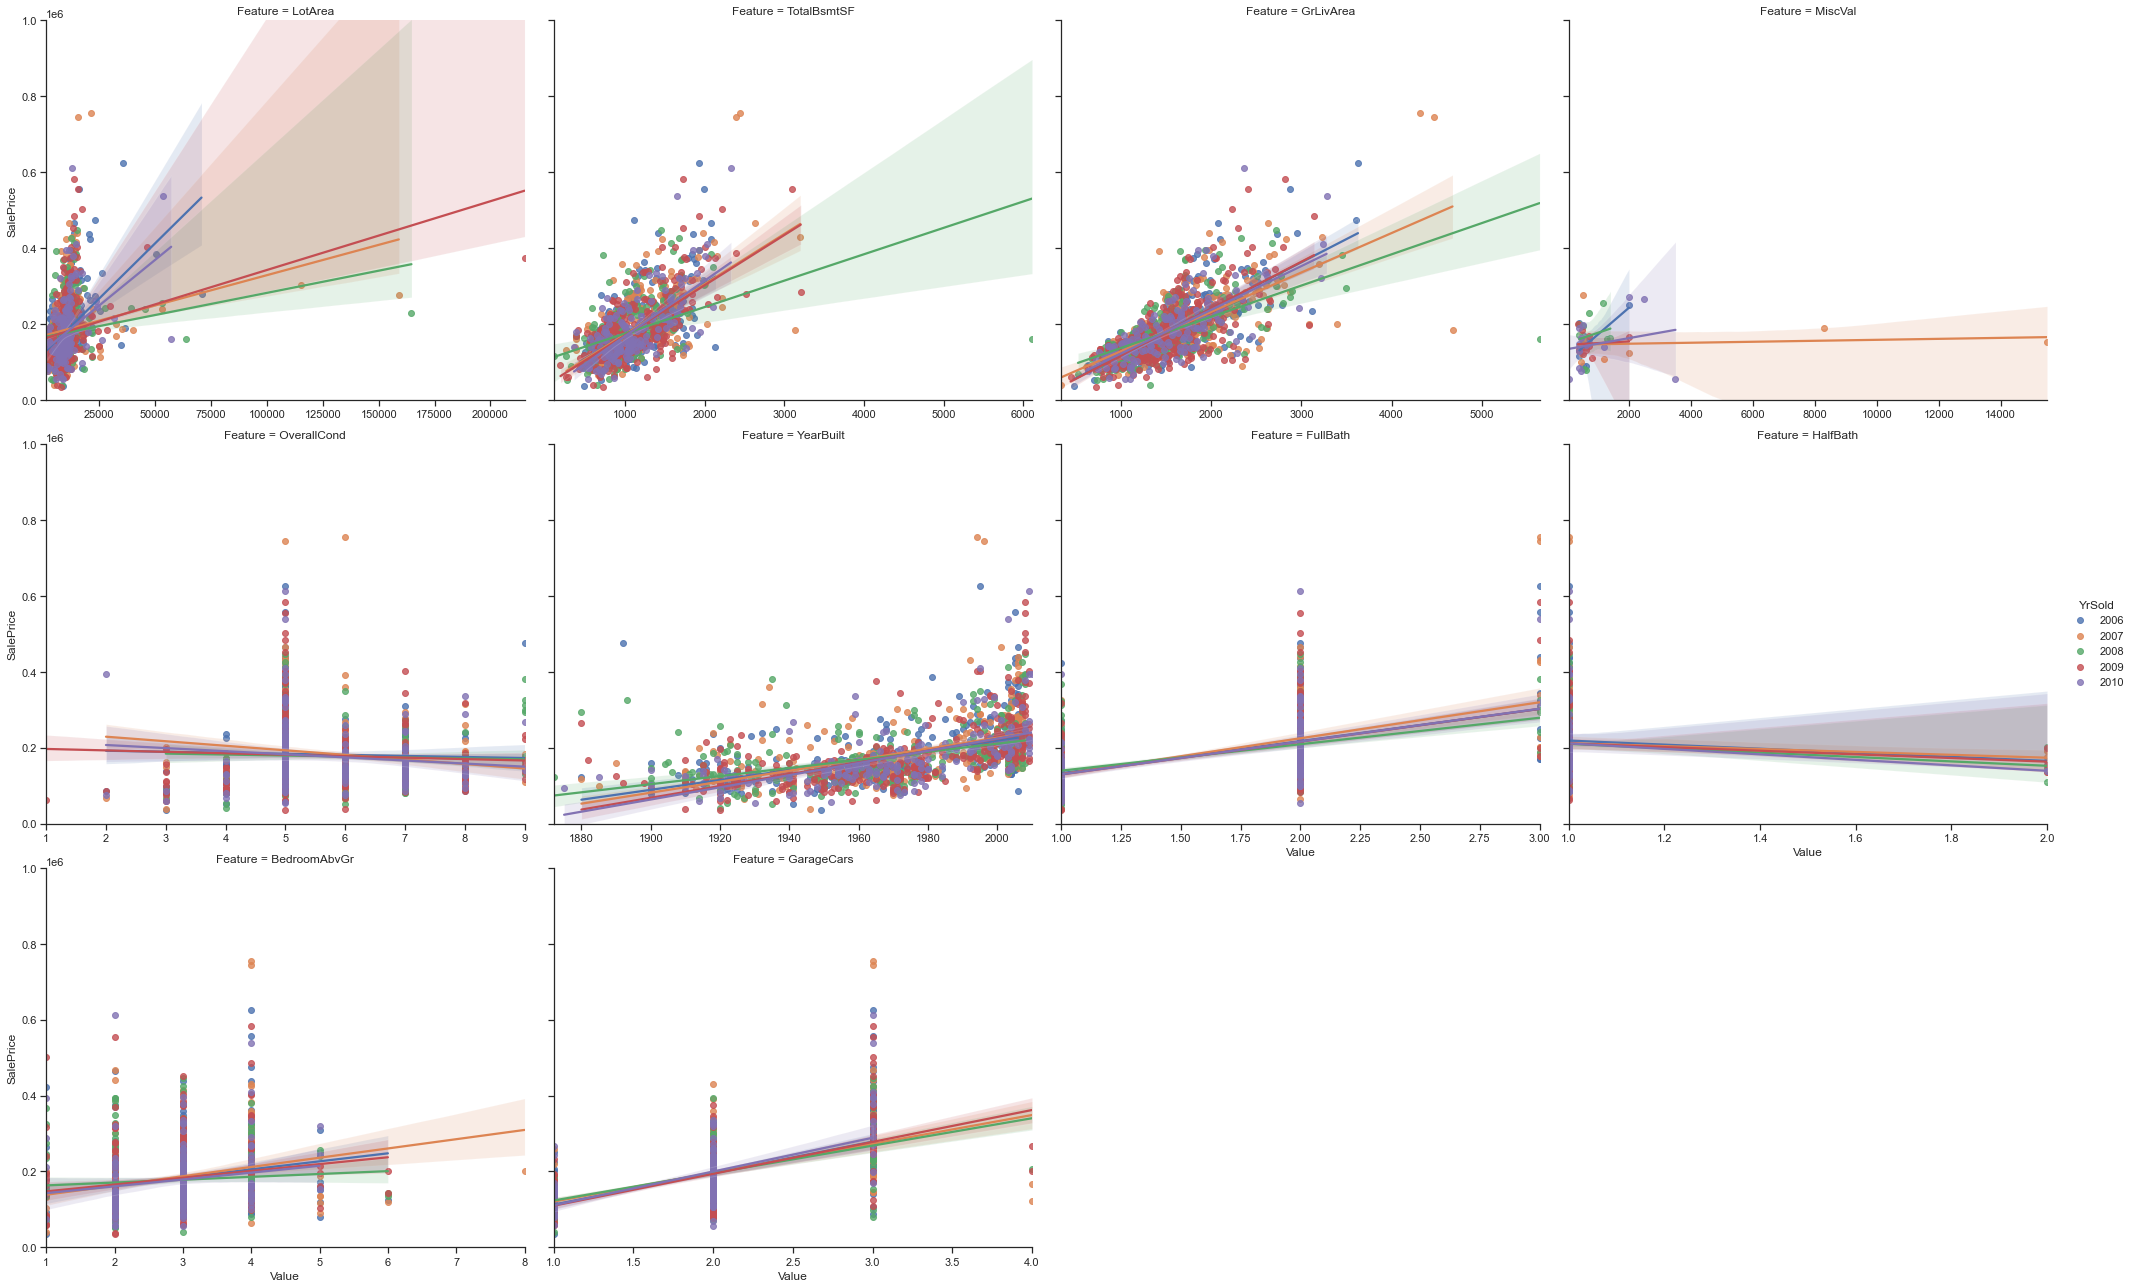

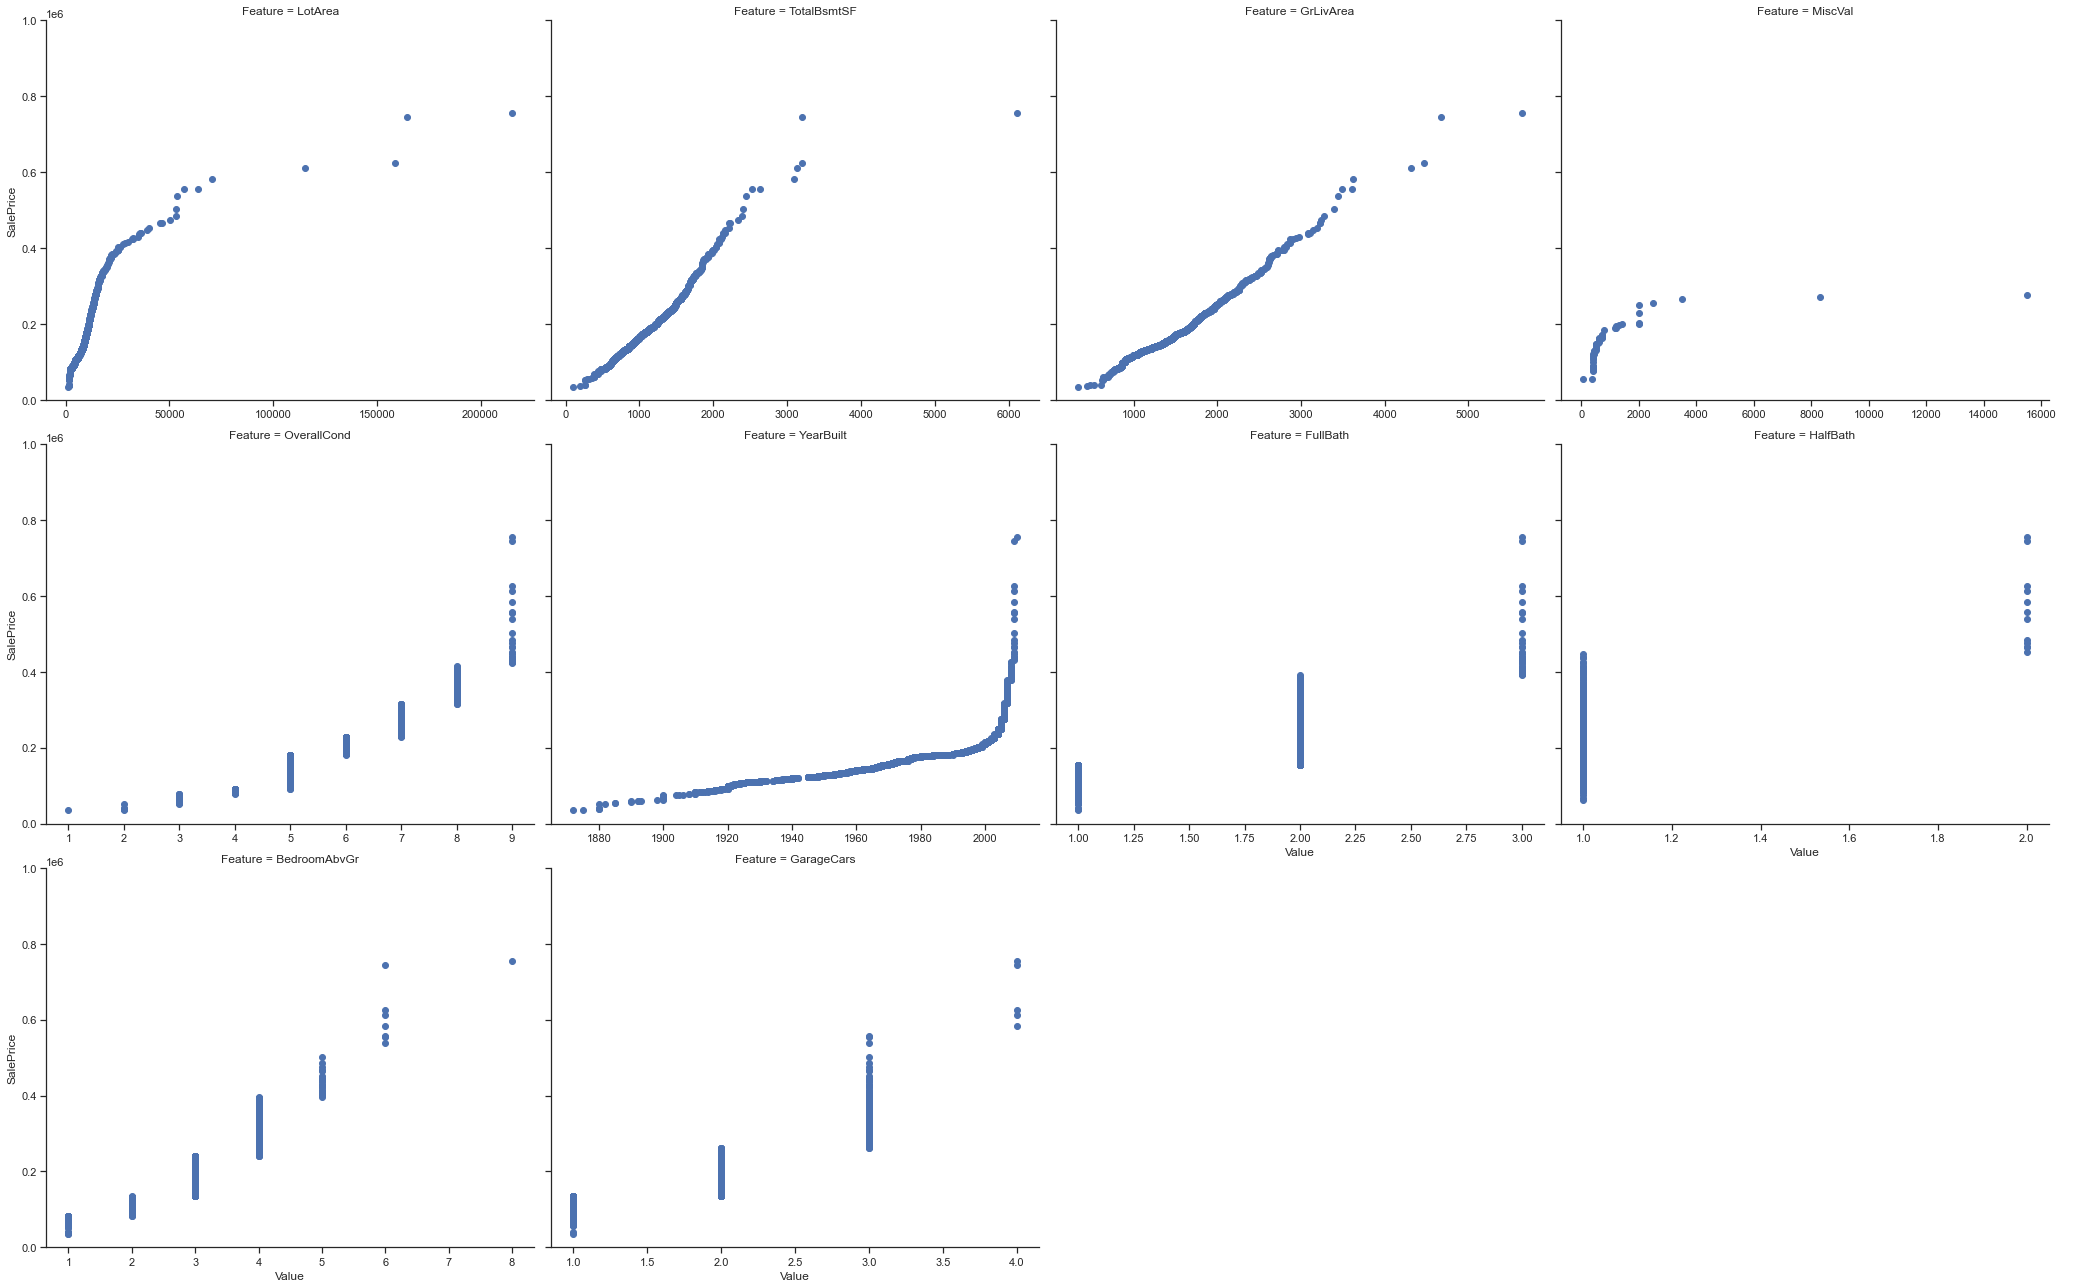

In [7]:
cols = ['LotArea', 'TotalBsmtSF', 'GrLivArea', 'MiscVal', 
        'OverallCond', 'YearBuilt', 'FullBath', 'HalfBath', 
        'BedroomAbvGr', 'GarageCars']


# ----- Plot histograms of the core Numeric Features, segment by YrSold in case there are obvious patterns between years
# Melt (stack) our DataDrame to make visulization easier in Seaborn
ames2_df = pd.melt(ames_df.reset_index(), id_vars=['Id', 'YrSold'], value_vars=cols+['SalePrice'], var_name='Feature', value_name='Value')

g = sns.FacetGrid(col='Feature', hue='YrSold', data=ames2_df, 
                  sharex=False, sharey=True,
                  height=6, aspect=1.2, col_wrap=4, margin_titles=True)
g.map(plt.hist, "Value", bins=15, alpha=0.5)
g.add_legend()


# ----- Plot scatter (with regression lines) of the core Numeric Features, segment by YrSold in case there are obvious patterns between years
# Note: I'm removing 0 values so the regression lines reflect relationship if that feature exists

# Melt (stack) our DataDrame to make visulization easier in Seaborn
ames2_df = pd.melt(ames_df.reset_index(), id_vars=['Id', 'SalePrice', 'YrSold'], value_vars=cols, var_name='Feature', value_name='Value')

g = sns.FacetGrid(col='Feature', hue='YrSold', data=ames2_df[ames2_df['Value'] > 0], 
                  height=6, aspect=1.2, col_wrap=4, ylim=(0, 1000000), 
                  sharey=True, sharex=False, margin_titles=True)
g.map(sns.regplot, "Value", "SalePrice")
g.add_legend()


# ----- Plot QQPlot of Numeric Features - explore skew
# Note: I'm removing 0 values so the regression lines reflect relationship if that feature exists

# Melt (stack) our DataDrame to make visulization easier in Seaborn
ames2_df = pd.melt(ames_df.reset_index(), id_vars=['Id', 'SalePrice', 'YrSold'], value_vars=cols, var_name='Feature', value_name='Value')

# ----- qqplot helper function 
def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    plt.scatter(xr, yr, **kwargs)

g = sns.FacetGrid(col='Feature', data=ames2_df[ames2_df['Value'] > 0], 
                  height=6, aspect=1.2, col_wrap=4, ylim=(0, 1000000), 
                  sharey=True, sharex=False, margin_titles=True)
g.map(qqplot, "Value", "SalePrice")
g.add_legend()

#### Explore Categorical Features

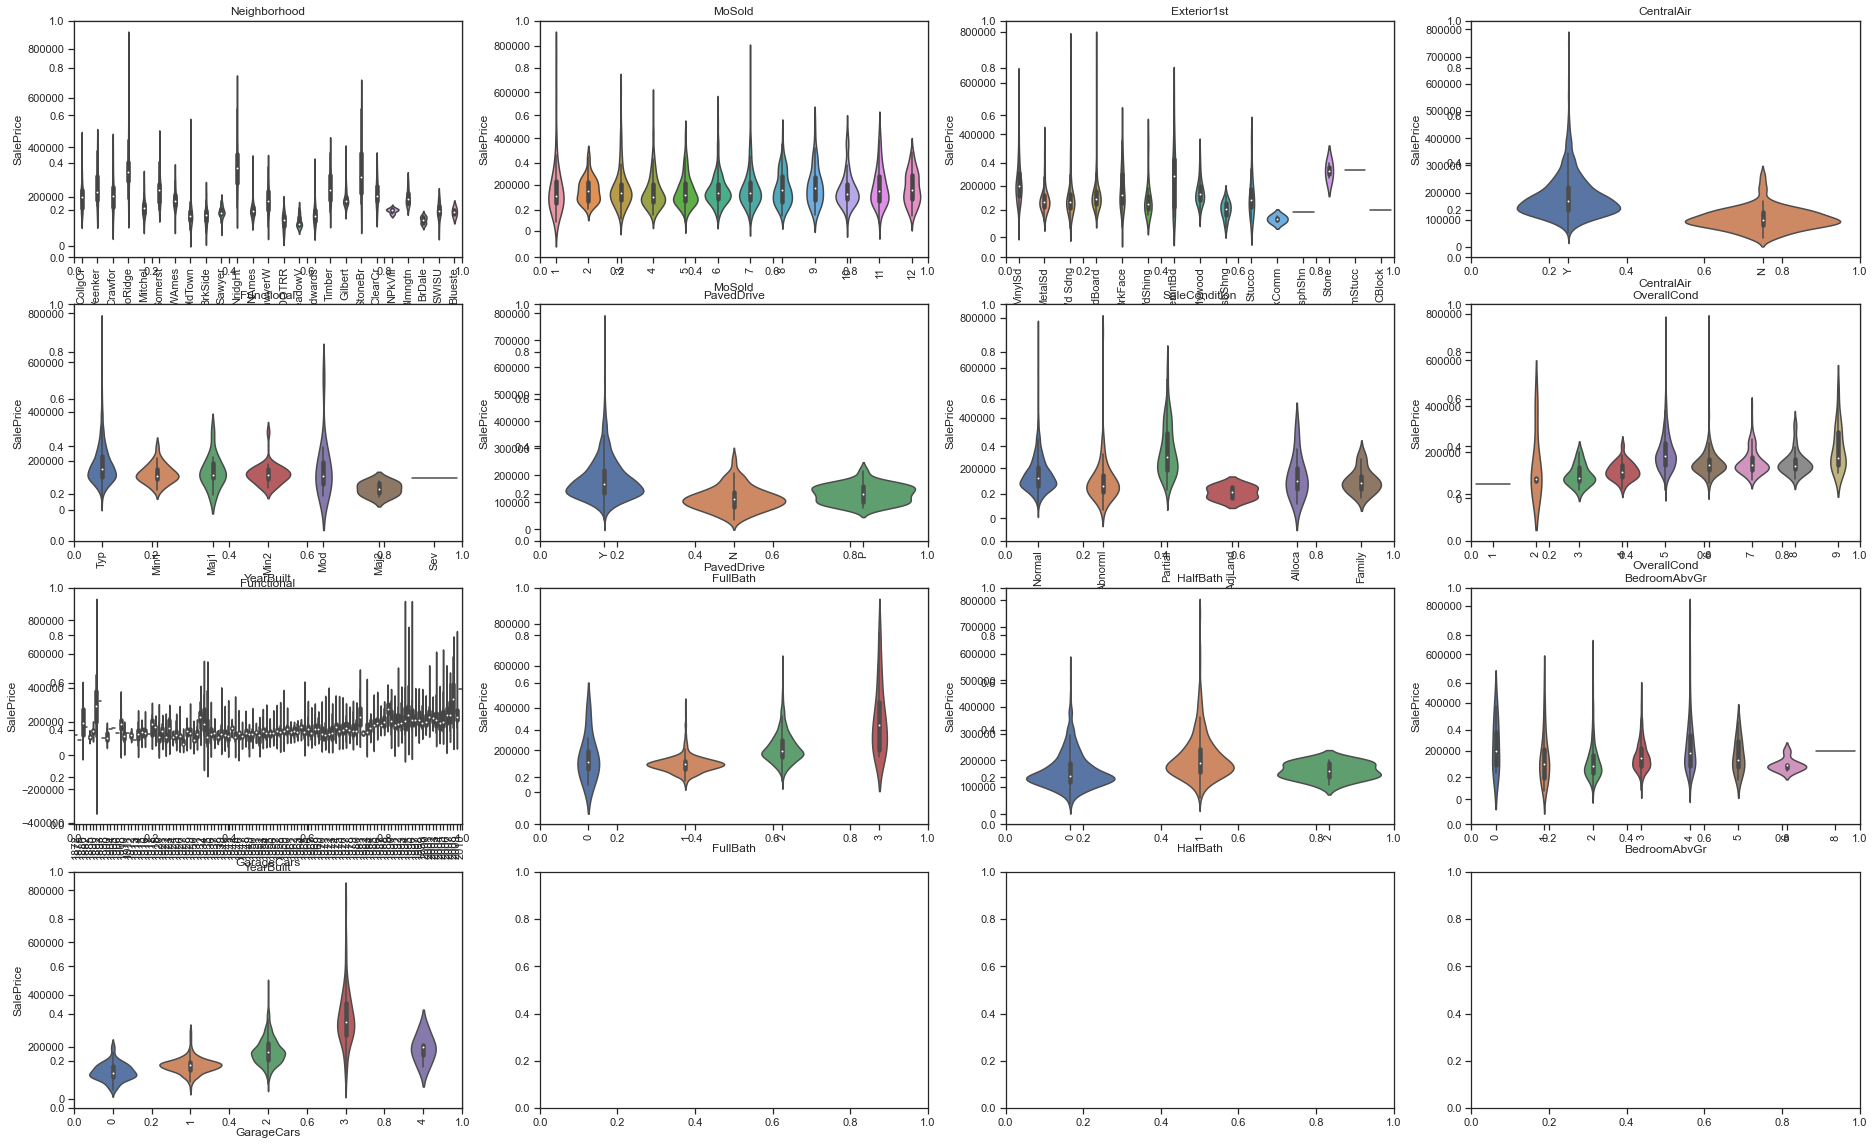

In [8]:
# Categorical features of interest
cols = ['Neighborhood', 'MoSold', 'Exterior1st', 'CentralAir', 
        'Functional', 'PavedDrive', 'SaleCondition', 'OverallCond', 'YearBuilt', 
        'FullBath', 'HalfBath', 'BedroomAbvGr', 'GarageCars']

# Create a new matplotlib grid (4x4) to place violin plots
fig, ax = plt.subplots(4, 4, figsize=(32, 20))

# Loop thru features and add subplots to FacetGrid
for i, c in enumerate(cols):  
    ax = fig.add_subplot(4, 4, i+1)
    ax = sns.violinplot(x=c, y="SalePrice", data=ames_df)
    ax.set_title(c)    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

Based on preliminary visualizations, remove the following features:

* **MiscVal**
* **HalfBath**
* **OverallCond** - this has a non-linear trend
* **BedroomAbvGr** - this has a non-linear trend
* **YearBuilt** - While there is a trend (newer is more expensive), it's not really a linear relation and log transforming year doesn't make sense

Keep the following:

* **GrLivArea** but log transform it
* **LotArea** but log transform it
* **YearBuilt**
* **FullBath**
* **GarageCars**
* **CentralAir** - Boolean Yes or No
* **PavedDrive** - Boolen Yes, group Partial and No into a single group
* **Neighborhood** - categorical
* **Exterior** - categorical
* **MoSold** - categorical

Note: LotArea, SalePrice, YearBuilt all show strong skew.  We will need to try and normalize these with a log transform.


# Data Wrangling/Cleaning
Please perform some basic transformations/data manipulations.  

Resources:


*   https://pandas.pydata.org/docs/user_guide/index.html



In [9]:
def clean_data(df):
    """Clean the provided dataframe and return a simplified dataframe.  This lets us easily clean both the training and later test datasets."""

    # Build a new DataFrame with only the features we care about.  Also filter to only include SaleCondition== "Normal" (recommended by dataset author) and Functional="Typ" (ie typical properties)    
    if 'SalePrice' in df:
        cols = ['GrLivArea', 'LotArea', 'FullBath', 'GarageCars', 'CentralAir', 'PavedDrive', 'Neighborhood', 'MoSold', 'SalePrice' ]
    else:
        cols = ['GrLivArea', 'LotArea', 'FullBath', 'GarageCars', 'CentralAir', 'PavedDrive', 'Neighborhood', 'MoSold' ]
        
    # if working with training data, filter to only Normal & Typical sales
    if 'SalePrice' in df:
        out = pd.DataFrame(df[(df['SaleCondition']=='Normal') & (df['Functional']=='Typ')][cols])
    else:
        out = pd.DataFrame(df[cols])
        
    # Log transform the living area, lot size, sale price
    out['GrLivArea'] = out['GrLivArea'].apply(lambda x: np.log(x))
    out['LotArea'] = out['LotArea'].apply(lambda x: np.log(x))
    
    if 'SalePrice' in df:
        out['SalePrice'] = out['SalePrice'].apply(lambda x: np.log(x))

    # Convert Central Air and paved drive into boolean
    out['CentralAir'] = out['CentralAir'].apply(lambda x: 1 if x in ['Yes', 1] else 0)
    out['DriveWay'] = out['PavedDrive'].apply(lambda x: 1 if x in ['Y'] else 0)

    # Create a new feature, Exterior
    out['Neighborhood'] = out['Neighborhood'].astype('category')
    out['MoSold'] = out['MoSold'].astype('category')

    return out

feature_df = clean_data(ames_df)

# Sanity checck new DataDrame 
feature_df.describe()

,GrLivArea,LotArea,FullBath,GarageCars,CentralAir,SalePrice,DriveWay
count,1108.000000,1108.000000,1108.000000,1108.00000,1108.0,1108.000000,1108.000000
mean,7.246200,9.100998,1.538809,1.73917,0.0,12.018020,0.916968
std,0.331112,0.514785,0.533715,0.70846,0.0,0.364213,0.276056
min,5.811141,7.170120,0.000000,0.00000,0.0,10.578980,0.000000
25%,6.997139,8.927812,1.000000,1.00000,0.0,11.782953,1.000000
50%,7.273093,9.145215,2.000000,2.00000,0.0,12.001199,1.000000
75%,7.469083,9.342793,2.000000,2.00000,0.0,12.254863,1.000000
max,8.370084,12.279532,3.000000,4.00000,0.0,13.534473,1.000000


### Identify and Remove Outliers

Note that I don't usually remove outliers unless there is a very compelling reason.  In this situation, the author of the dataset recommended removing extreme values as they tend to represent property edge cases that don't generalize.  I will remove SalePrices > \$500k and properties where the LotArea or GrLivArea exceeds 3 standard deviations.  If we were doing a more rigorous analysis, I would instead isolate specific points to understand whether to include/exclude them.  For example, rather than just removing extreme LotArea, SalePrice, or GrLivArea, it might make more sense to see if outliers are combinations - large Lot or Living area but low price, or high price and low Lot or Living area, etc.  The qualitative removal of outliers is safer than setting cutoffs.

In [10]:
# Calculate z-scores to help with identify extreme values
feature_df['LotArea_z'] = zscore(feature_df['LotArea'])
feature_df['GrLivArea_z'] = zscore(feature_df['GrLivArea'])
feature_df['SalePrice_z'] = zscore(feature_df['SalePrice'])

# Remove values > 3 standard deviations
feature_df = feature_df[feature_df['LotArea_z']<=3]
feature_df = feature_df[feature_df['GrLivArea_z']<=3]

# Remove very expensive homes - recommended by the dataset author
feature_df = feature_df[feature_df['SalePrice']<=np.log(500000)]

# Remove z-scores - we don't need them any more
feature_df.drop(['LotArea_z', 'GrLivArea_z','SalePrice_z'], axis=1, inplace=True)


# Data Visualizations

Include supporting data visualizations here.  You may use any visualization library of your choice.  **You must explain what each visualization is showing.**

Resources:

*   https://plotly.com/python/plotly-express/
*   https://seaborn.pydata.org/introduction.html
*   https://matplotlib.org/



### Verify Continuous Features

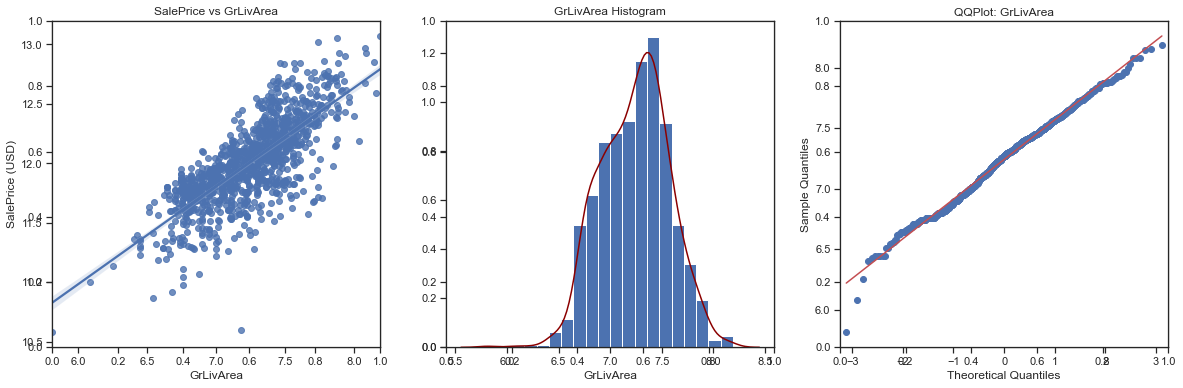

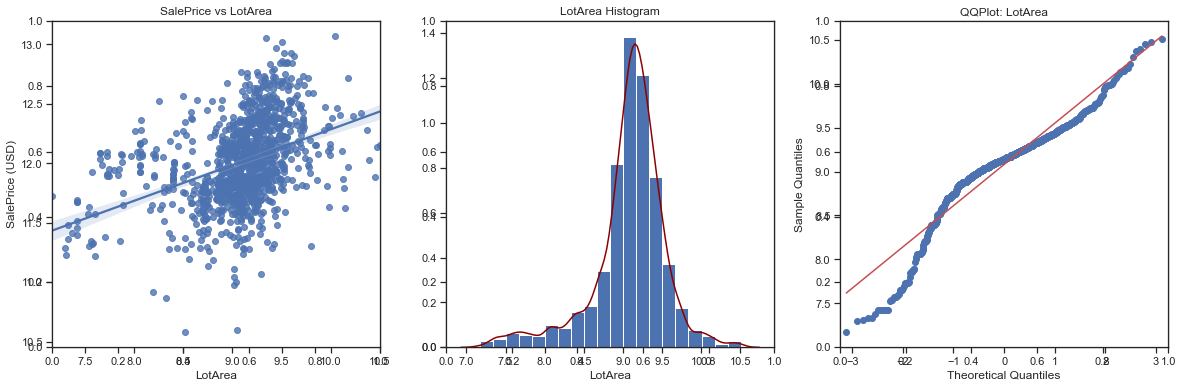

In [11]:
# ---- For each Continuous Feature, verify assumptions, e.g. plot QQ, residauls, histogram, scatter
cols = ['GrLivArea', 'LotArea']

for i, c in enumerate(cols):
    # Create a new matplotlib grid (4x4) to place violin plots
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    # Scatter Plot column against Sale Price
    ax = fig.add_subplot(1, 3, 1)
    sns.regplot(x=c, y="SalePrice", data=feature_df[feature_df[c] > 0], ax=ax)
    ax.set_title('SalePrice vs '+c)
    ax.set_ylabel('SalePrice (USD)')
    
    ax = fig.add_subplot(1, 3, 2)
    ax = sns.distplot(feature_df[c], bins=20, hist_kws=dict(alpha=1), kde_kws={"color": "darkred"})
    ax.set_xlabel(f'{c}')
    ax.set_title(f'{c} Histogram')
    
    # Plot QQplot for Continuous variables
    ax = fig.add_subplot(1, 3, 3)
    sm.qqplot(feature_df[c], line ='s', ax=ax) 
    ax.set_title('QQPlot: '+c)    
    plt.show()



#### Feature Correlations

Linear models perform better with good input data and are sensitive to non-normal data.  Ideally, input features should be "normal" and care taken with outliers, especially high leverage points.  For linear models, we should see a linear relationship between each input feature and the response variable.  Models can also be sensitive to multicollinearity - correlation between input features.  Ideally, features should not be correlated, and if there is a high degree of correlation, potentially using a technique like PCA to reduce the feature set.

Text(0.5, 1.0, 'Correlation Matrix')

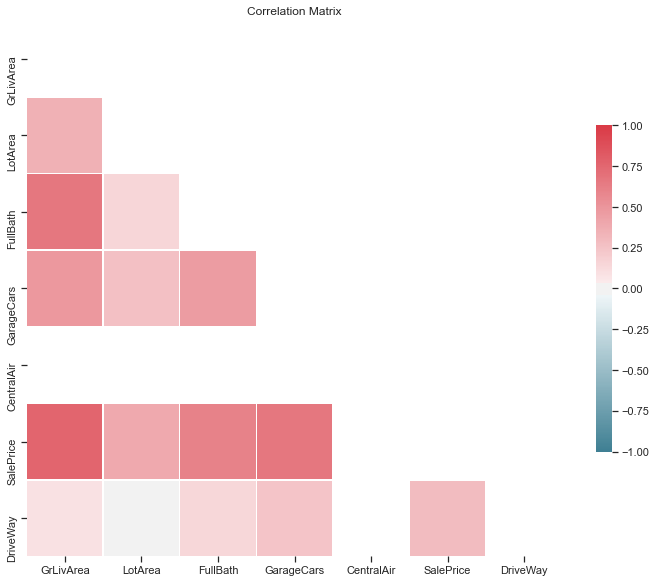

In [13]:
# Compute the correlation matrix
corr = feature_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation Matrix')

Notes:

* **SalePrice** fits our assumptions - the data is normal (see the histogram and Q-Q plot).  
* **GrLivArea** fits our assumptions - the data is normal (see the histogram and Q-Q plot), and shows a reasonable linear relationship with SalePrice
* **LotArea** is generally normal but does have some skew in the lower lot sizes, so we would expect our model to lose performance in the lower range.  There does appear to be a generally linear relationship between LotArea and SalePrice.

* **GarageCars, FullBath and LotArea** all loosely correlate with **GrLivArea**, however the correlation is < ~0.5 which isn't super strong.  As such, when building our model, we will include them, but then try removing to see whether they offer any additional resolution.



# Build Model

I will build a simple Multiple Regression model.  The reality is that we do have minor multicolineararity and our features are not perfectly linear - a more tolerant algorithm would probaly perform better, but this will provide a good starting point.

### Prepare data for model

To better measure the model's capability to generalize we want to measure how it performs against a dataset it wasn't trained on.  I will breakout a validation dataset (20% of the main training data) and use that to calcualte RMSE.  

In [14]:
# Convert categorical features to dummy - via one-hot-encoding
feature_df = pd.get_dummies(feature_df, drop_first=True)

In [15]:
y = pd.DataFrame(feature_df['SalePrice'])

# All the features
x = feature_df.drop(['SalePrice'], axis=1)

# prepare a string version of the features to insert into the model equation
predictors = ' + '.join(x.columns)

# Create a validation holdout group to test model against
X_train, X_validation, y_train, y_validation = train_test_split(x, y, test_size=0.2, random_state=42)


In [16]:
# Note: StatsModels requires all columns in a single DataFrame and uses an exation to identify response vs target vars
train_combined = pd.concat([X_train, y_train], axis=1)

# Fit our model
reg = smf.ols(f'SalePrice ~ {predictors}', data=train_combined).fit()
print('Model Summary')
print(reg.summary())

# Kaggle uses RMSE
mse=metrics.mean_squared_error(train_combined['SalePrice'], reg.predict(train_combined))
rmse = np.sqrt(mse)
print(f'\nRMSE with Training Data: {rmse}\n')


Model Summary
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     95.01
Date:                Sun, 17 May 2020   Prob (F-statistic):          4.55e-283
Time:                        20:14:37   Log-Likelihood:                 427.95
No. Observations:                 876   AIC:                            -771.9
Df Residuals:                     834   BIC:                            -571.3
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept         

### _Four Assumptions for a Linear Model_
1. Linearity - each feature shows a linear relationship with the response variable (view scatter plot)
2. Normality - each feature is normally distributed.
3. Independence - each record in our data set is separate.  As noted at the beginning, there is, in fact, some dependence between records since sale prices are based on comps (recent sales) and concurrently selling houses are competing against each other which could drive prices up or down.
4. Heteroscedasticity - the variance of residuals is the same for any value of X (we don't see any patterns in the residuals)


#### 1. Residual Linearity & Variance

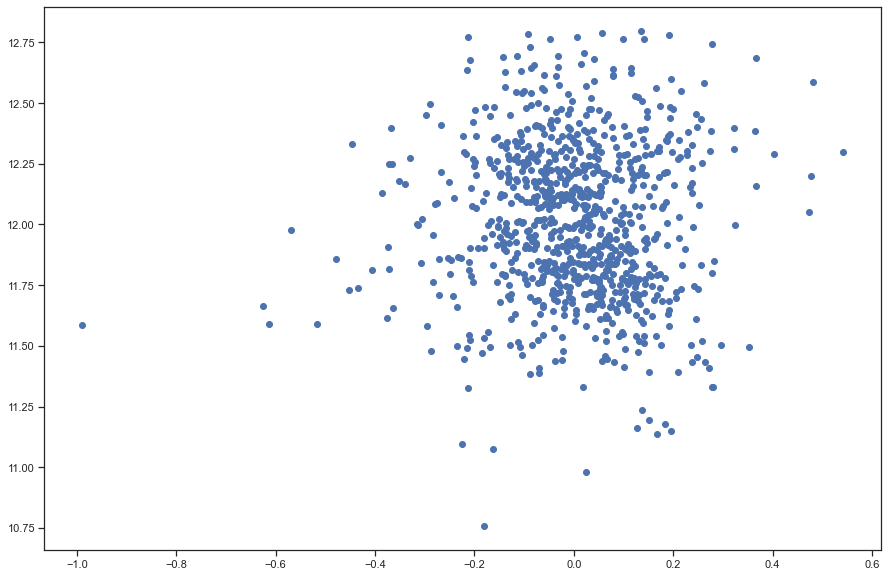

In [17]:
# Plot residuals vs predicted value - we expect residulas to be randomly distributed
pred_val = reg.fittedvalues.copy()
true_val = train_combined['SalePrice']
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(15,10))
_ = ax.scatter(residual, pred_val)

Note: Overall there is random spread, however, we do see a slight pattern between the ends and middle.  THis isn't perfect and suggests the model is performing differently at the end regions.  

#### 2. Normality

0.9664577732540826

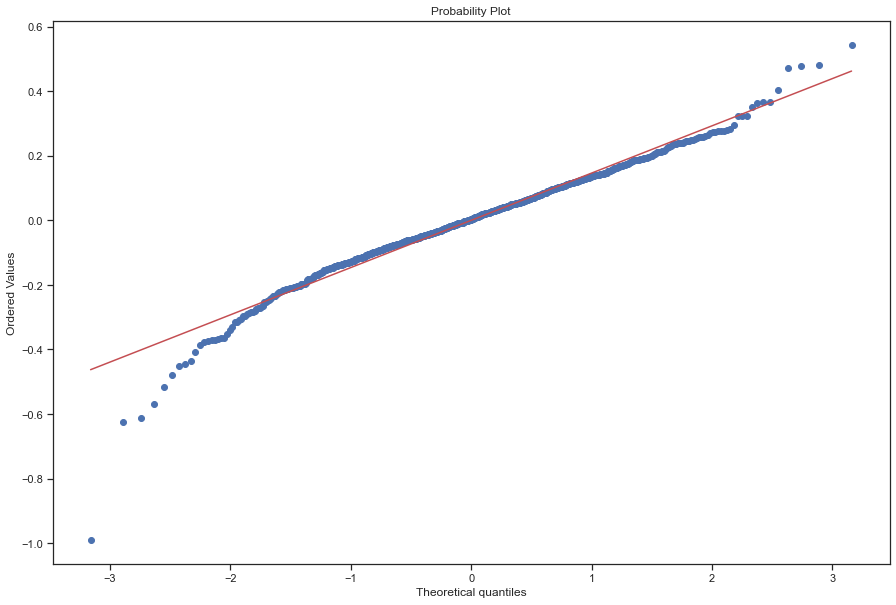

In [18]:
import scipy as sp
fig, ax = plt.subplots(figsize=(15, 10))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

We see clearly that the models drifts near the ends.  As such we expect the model to perform better in the middle quariles and less in the outer quartiles.  

### Model Performnance on Validation Dataset

In [19]:
# Kaggle uses RMSE
mse=metrics.mean_squared_error(y_validation, reg.predict(X_validation))
rmse = np.sqrt(mse)
print(f'RMSE with Validation Data: {rmse}\n')


RMSE with Validation Data: 0.15084802016570184



### Calculate Test Predictions for Linear Model Submission

In [20]:
# Load Test Data Set from csv
test_df = pd.read_csv('./datasets/test.csv')
print('Rows loaded: ', test_df['Id'].count())

test_df.set_index('Id', inplace=True)
test_df.fillna(0, inplace=True)

# Apply necessary tranforms (same as we performed above when training)
test_df = clean_data(test_df)
display(test_df.head())
print('Rows remaining: ', test_df['LotArea'].count())

# Convert categorical features to dummy - via one-hot-encoding
test_df = pd.get_dummies(test_df, drop_first=True)
display(test_df.head())

# Calculate Predictions
test_df['SalePrice'] = np.exp(reg.predict(test_df))

test_df['SalePrice'].to_csv('./datasets/final_submission.csv', header=True)

test_df['LotArea'].count()

Rows loaded:  1459


,GrLivArea,LotArea,FullBath,GarageCars,CentralAir,PavedDrive,Neighborhood,MoSold,DriveWay
Id,,,,,,,,,
1461,6.797940,9.360655,1,1.0,0,Y,NAmes,6,1
1462,7.192182,9.565704,1,1.0,0,Y,NAmes,6,1
1463,7.395722,9.534595,2,2.0,0,Y,Gilbert,3,1
1464,7.380256,9.208138,2,2.0,0,Y,Gilbert,6,1
1465,7.154615,8.518193,2,2.0,0,Y,StoneBr,1,1


Rows remaining:  1459


,GrLivArea,LotArea,FullBath,GarageCars,CentralAir,DriveWay,PavedDrive_P,PavedDrive_Y,Neighborhood_Blueste,Neighborhood_BrDale,...,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12
Id,,,,,,,,,,,,,,,,,,,,,
1461,6.797940,9.360655,1,1.0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1462,7.192182,9.565704,1,1.0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1463,7.395722,9.534595,2,2.0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1464,7.380256,9.208138,2,2.0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1465,7.154615,8.518193,2,2.0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


1459

### Kaggle Result for Multiple REgression Model

0.20198 (Leaderboard #4084)

# Conclusions 

The Ames House Prices provided a nice dataset for exploring relationships between features and building a simple Multiple Regression linear model.  With linear models, we ideally want to choose the fewest features that explain the most variability.  If this were a more rigorous study, we'd have started with all features and eliminated them slowly until we had the most critical that predict the price.  I chose to filter the initial list based on anecdotal experience to an initial ~20 features for exploration.  Based on simple scatter, histogram and Q-Q plots, I restricted this list to: 

* LotArea, GrLivArea, YearBuilt, FullBath, GarageCars, CentralAir, PavedDrive, Neighborhood, Exterior, MoSold

These features show a possible linear relationship, show good variability between values, and broadly show a low correlation between them.  One feature I dropped out, OverCond, could possibly be included if it were treated as a categorical feature rather than ordinal.  There was also an interesting pattern with bedrooms where properties with 5+ bedrooms sold less than lower numbers.  In a more rigorous analysis, we would try to include these features to get better resolution.  However, I was looking for excuses to reduce the number of included features to simplify the model.

For the continuous features: LotArea and GrLivArea, I removed extreme high values (> 3 standard deviations).  I also log-transformed these features to help normalize them, reducing skew.  I also log-transformed the response variable, SalePrice, and removed properties with SalePrice's greater than 500k.  The dataset author raised the concern that more expensive homes (> 400k) do not generalize well with linear models.  I also filtered out property sales that were not "Typical" or where the SaleCondition was not "Normal".  Again, per the dataset author, these property sales are a smaller percentage and represent unusual edge cases and aren't ideal for simple models.  For the categorical features, I used one-hot encoding to convert them to an appropriate form for linear regression.  

The simple linear model using the Training Data performed well with an RSME of ~0.1485 and Adj-R squared of ~0.815.  The included features explain about 81.5% of the variability in the SalePrice and is reasonable for a quick model.  I next calcualted the RMSE for the Validation (Holdout) Data as 0.1508.  This is very close to the Training Data, which suggests the model generalized well.  The lower the Validation Data RMSA relative to the Training Data RMSA, the more overfit our model might be.  

While 81.5% explanation is a good starting point, it is probably quite a bit lower than we could achieve with further modeling.  Next steps might include further exploration of features not included in this model.  We could also try feature removal (dropping out features with low p-value) and/or a cross-validation approach with Ridge Regression.  Ridge Regression handles multicollinearity and we know that there is a correlation between the current features which isn't ideal with Linear Models.  As feature correlations increase, linear model performance decreases.  If we aren't restricted to Linear Models, we could explore models that are tolerant of non-linear data and multicollinearity.  Lastly, ensemble models composed of several top-performing single models will usually perform better than the single models alone.  Those were outside the scope of this assignment.


# Bonus: Keras NN Model

I was curious how a quick and dirty Keras Model would perform.  NN are resiliant to non-linear relationships, multicolineararity, etc.  

Kaggle Result: **0.15280 (Leaderboard #3130)** (I made 2 submission - playing with the optimizer, activation and hidden node count)

/Users/dlofland/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/dlofland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/dlofland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/dlofland/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/dlofland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: DataConversionWarning: Data with input dtype int64 were all converted 

Epoch 1/40
37/37 [==============================] - 0s 4ms/step - loss: 0.7686 - val_loss: 0.2911
Epoch 2/40
37/37 [==============================] - 0s 2ms/step - loss: 0.2535 - val_loss: 0.2075
Epoch 3/40
37/37 [==============================] - 0s 2ms/step - loss: 0.0999 - val_loss: 0.1639
Epoch 4/40
37/37 [==============================] - 0s 1ms/step - loss: 0.0570 - val_loss: 0.1511
Epoch 5/40
37/37 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.1469
Epoch 6/40
37/37 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.1423
Epoch 7/40
37/37 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.1583
Epoch 8/40
37/37 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.1535
Epoch 9/40
37/37 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.1666
Epoch 10/40
37/37 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1426
Epoch 11/40
37/37 [

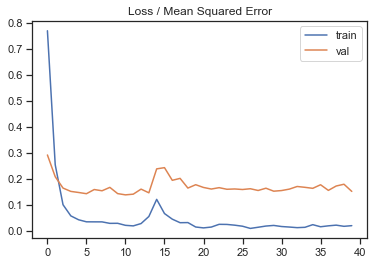

1459

In [21]:
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.initializers import RandomUniform
from matplotlib import pyplot

import os
import random
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

#-----------------------------Keras reproducible------------------#
SEED = 1234

tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)
#-----------------------------------------------------------------#

# Load Training Data Set from csv
train = pd.read_csv('./datasets/train.csv')
train['isTraining'] = 1

train_y = pd.DataFrame(train['SalePrice'])
train.drop('SalePrice', inplace=True, axis=1)

test = pd.read_csv('./datasets/test.csv')
test['isTraining'] = 0

# I combine both Training and Test data so that the Scaler and pd.Dummies() are
# exposed to all possible values.  Technically, it is better to only do this fitting on 
# the training data then use that scaler on the test (holdout) data.  If I were
# doing a more rigorous analysis, I would correctly separate these so there is no
# leakage between the training and test datasets.
df = pd.concat([train, test], ignore_index=True)
df.set_index('Id', inplace=True)
df.fillna(0, inplace=True)
df['PropertyAge'] = df['YrSold'] - df['YearBuilt']

df = pd.get_dummies(df, drop_first=True)

# Create Input Feature Scaler
scaler = StandardScaler()
scaler.fit(df)

train_df = df[df['isTraining']==1].copy()
normalized_train = scaler.transform(train_df)

test_df = df[df['isTraining']==0].copy()
normalized_test = scaler.transform(test_df) 

# Create Scaler for Output SalePrice (so we can invert later)
yscaler = StandardScaler()
yscaler.fit(train_y)
y_train = yscaler.transform(train_y)

# We need to drop the "isTraining" column
X = normalized_train[:, :-1]

# Create a validation holdout group to test model against
trainX, valX, trainy, valy = train_test_split(X, y_train, test_size=0.2, random_state=42)

# define model
model = Sequential()
model.add(Dense(256, input_dim=X.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='linear'))
model.add(Dense(1, activation='linear'))

# compile model
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.003)) # Adam(lr=0.01), SGD(lr=0.01, momentum=0.9)

# fit model
history = model.fit(trainX, trainy, validation_data=(valX, valy), epochs=40, verbose=1)

# evaluate the model
train_mse = model.evaluate(trainX, trainy, verbose=0)
val_mse = model.evaluate(valX, valy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, val_mse))

# plot loss during training
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

# Run predictions on Test Holdout Dataset
predictions = model.predict(normalized_test[:, :-1])
predictions = yscaler.inverse_transform(predictions)

test_df['SalePrice'] = predictions
test_df['SalePrice'].to_csv('./final_submission.csv', header=True)
test_df['LotArea'].count()



The simple Keras model bumped me up ~900 places in the leaderboard.  Not bad for a quick model.